In [13]:
import random

import cv2
from matplotlib import pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2
from data.transforms import RandomErasing

In [14]:
def visualize(image):
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(image)

In [15]:
from data.image import build_datasource
datasource = build_datasource('peta', '/datasets', False, False, True)

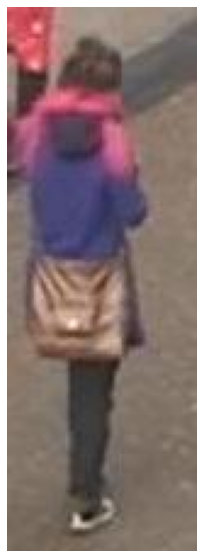

In [16]:
phase = 'test'
image_path, labels = datasource.get_data(phase)[random.randint(0, len(datasource.get_data(phase)))]

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_height, image_width, image_depth = image.shape

visualize(image)

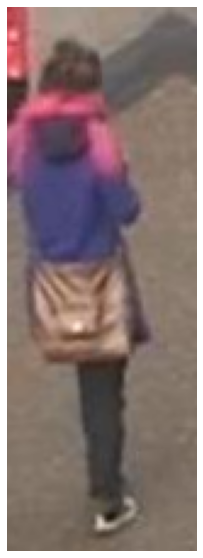

In [17]:
transform = A.Compose([
    A.Rotate(limit=45, always_apply=True)
    ])

transformed = transform(image=image)

visualize(transformed['image'])

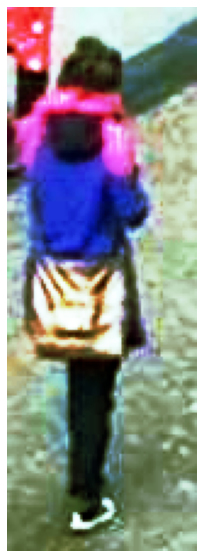

In [18]:
transform = A.Compose([
    A.Equalize(mode='cv', p=0.8, always_apply=True)
    ])

transformed = transform(image=image)

visualize(transformed['image'])

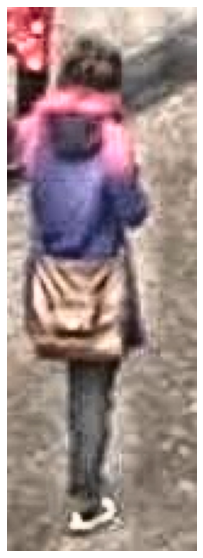

In [19]:
transform = A.Compose([
    A.CLAHE(p=0.8, always_apply=True)
    ])

transformed = transform(image=image)

visualize(transformed['image'])

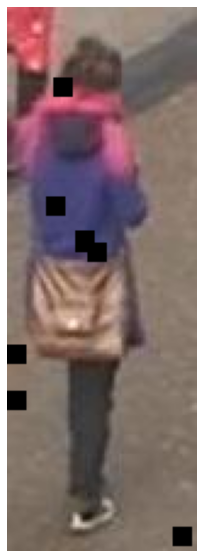

In [20]:
transform = A.Compose([
    A.Cutout(num_holes=8, always_apply=True)
    ])

transformed = transform(image=image)

visualize(transformed['image'])

In [21]:
image_size = [256, 128]

In [22]:
import torch
import torchvision.transforms.functional as F
class Denormalize(object):
    def __init__(self, mean, std, inplace=False):
        self.mean = mean
        self.demean = [-m/s for m, s in zip(mean, std)]
        self.std = std
        self.destd = [1/s for s in std]
        self.inplace = inplace

    def __call__(self, tensor):
        tensor = F.normalize(tensor, self.demean, self.destd, self.inplace)
        # clamp to get rid of numerical errors
        return torch.clamp(tensor, 0.0, 1.0)

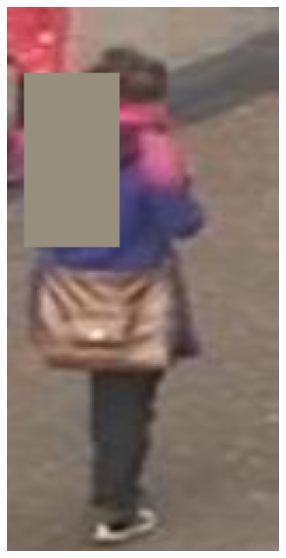

In [23]:
transform = A.Compose([
        A.Resize(image_size[0], image_size[1]),
        A.PadIfNeeded(min_height=image_size[0]+10, min_width=image_size[1]+10),
        A.RandomCrop(image_size[0], image_size[1]),
        A.HorizontalFlip(p=0.5),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
        ToTensorV2(),
        A.Lambda(image=RandomErasing(probability=1, mean=[0.485, 0.456, 0.406])),
    ])

transformed = transform(image=image)

visualize(Denormalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(transformed['image']).permute(1, 2, 0))